In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump
import datetime
%matplotlib inline

In [3]:
pwd = os.getcwd()

train_file_path = os.path.join(pwd, os.pardir, "data/train_clean.csv")
test_file_path = os.path.join(pwd, os.pardir, "data/test_clean.csv")
store_file_path = os.path.join(pwd, os.pardir, "data/store_clean.csv")

In [4]:
df_train = pd.read_csv(train_file_path, dtype={'StateHoliday': object}, parse_dates=["Date"])
df_test = pd.read_csv(test_file_path, dtype={'StateHoliday': object}, parse_dates=["Date"])
df_store = pd.read_csv(store_file_path)

In [5]:
df_train_store = pd.merge(df_train, df_store, how = 'left', on = 'Store')
df_test_store = pd.merge(df_test, df_store, how = 'left', on = 'Store')

In [6]:
sales_per_day = df_train_store.groupby(by="Date").agg({'Sales': 'mean'})

<AxesSubplot:title={'center':'Average Sales per Day'}, xlabel='Date'>

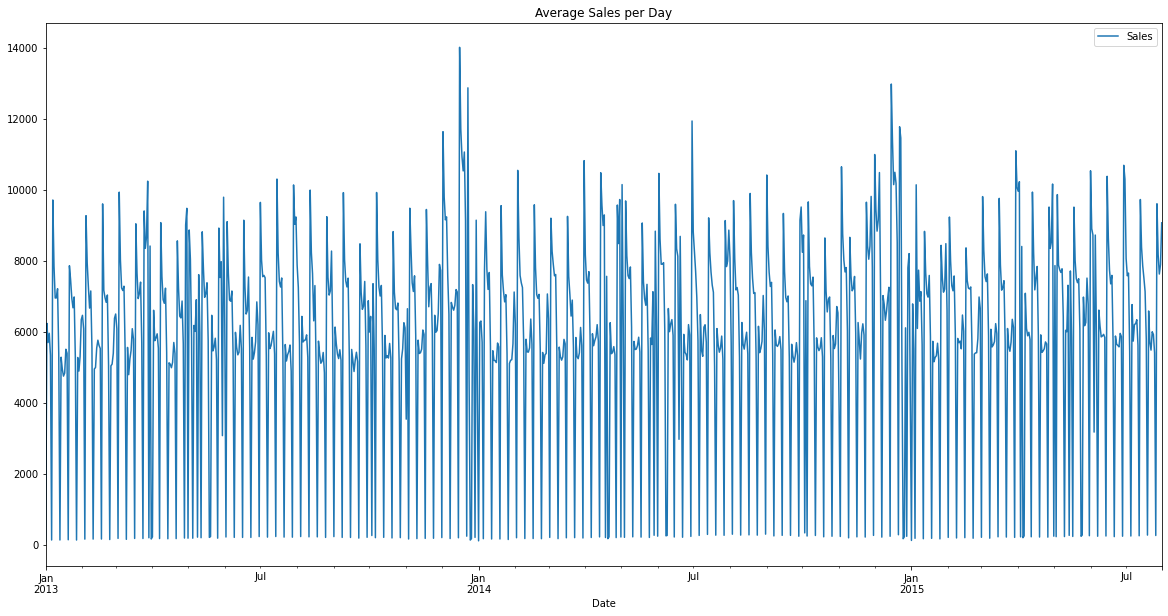

In [7]:
sales_per_day.plot(title="Average Sales per Day", figsize=(20, 10))

Looking at the graph we can say that it's stationary

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
result = adfuller(sales_per_day)

In [10]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.650823
p-value: 0.000001
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


Seeing the ADF value we can see that it's below the 1% value so we can reject the null hypothesis (data is non-stationary) which means our data is stationary

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [12]:
acf_days = acf(sales_per_day["Sales"].values, fft=True, nlags=941)
acfNp = np.array(acf_days)
pacf_days = pacf(sales_per_day["Sales"].values, nlags=200)
pacfNp = np.array(pacf_days)

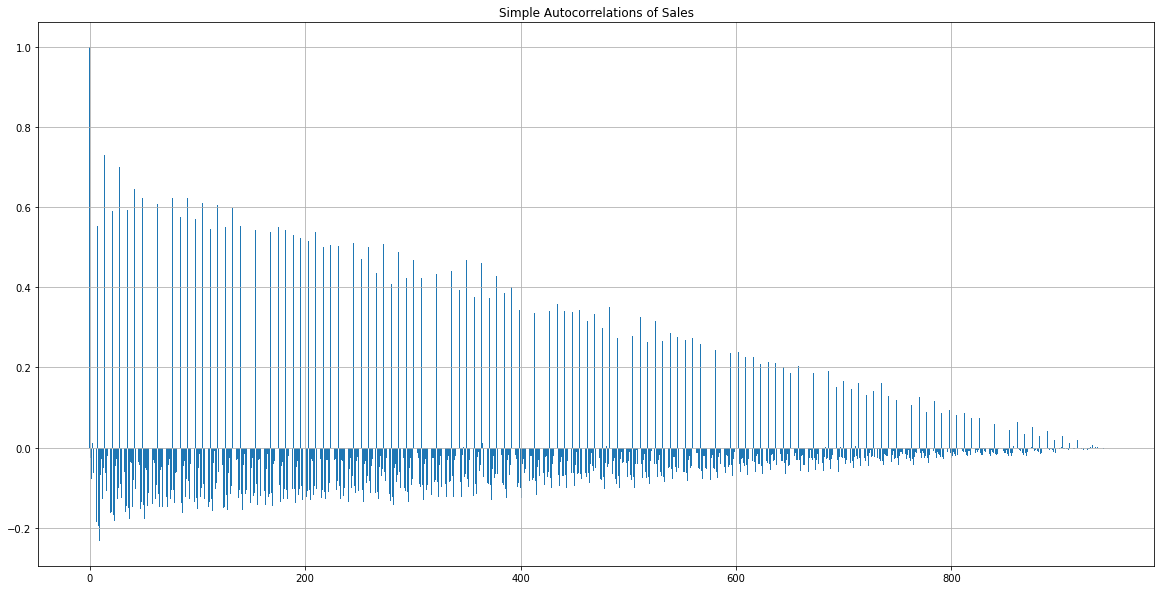

In [13]:
plt.figure(figsize=(20, 10))
plt.title(f"Simple Autocorrelations of Sales")
plt.bar(range(len(acfNp)), acfNp)
plt.grid(True)

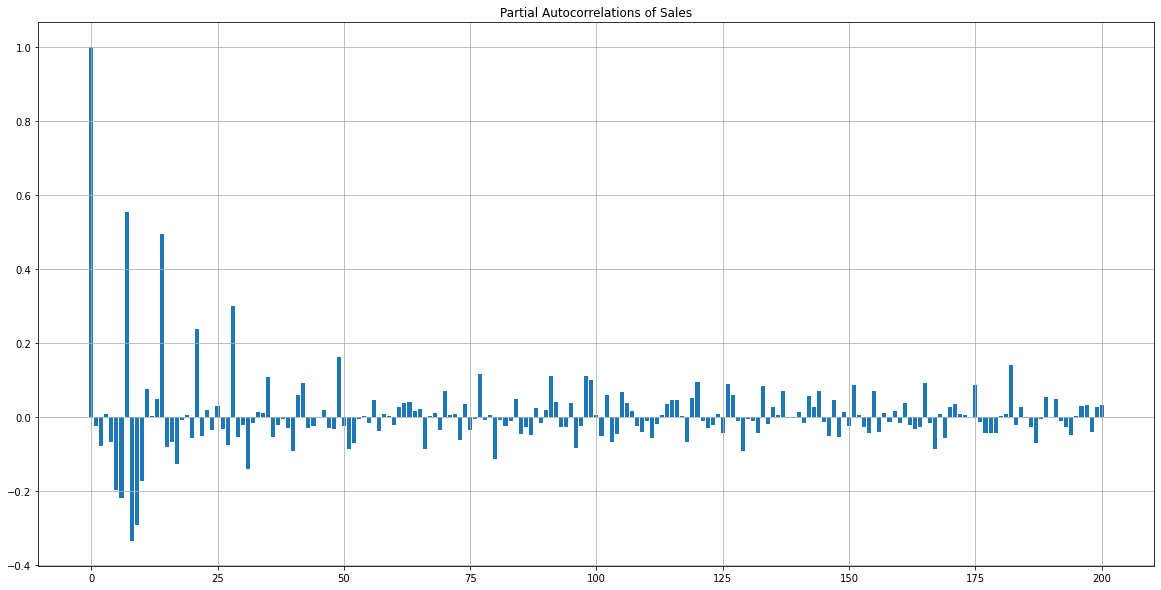

In [14]:
plt.figure(figsize=(20, 10))
plt.title(f"Partial Autocorrelations of Sales")
plt.bar(range(len(pacfNp)), pacfNp)
plt.grid(True)

In [15]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [16]:
scaler.fit(sales_per_day["Sales"].values.reshape([-1, 1]))

MinMaxScaler(feature_range=(-1, 1))

In [17]:
sales_per_day_scaled = scaler.transform(sales_per_day["Sales"].values.reshape(-1, 1))

In [18]:
sales_per_day["Scaled"] = sales_per_day_scaled

In [19]:
sales_per_day

,Sales,Scaled
Date,,
2013-01-01,87.284560,-1.000000
2013-01-02,6233.030493,-0.117299
2013-01-03,5693.112108,-0.194846
2013-01-04,5954.218834,-0.157344
2013-01-05,5337.751570,-0.245886
...,...,...
2015-07-27,9602.952466,0.366716
2015-07-28,8174.953363,0.161615
2015-07-29,7623.284305,0.082380


In [20]:
SIZE = len(sales_per_day["Scaled"])
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [21]:
DateTrain = sales_per_day.index.values[0:BATCH_SIZE]
DateValid = sales_per_day.index.values[BATCH_SIZE:]
XTrain = sales_per_day["Scaled"].values[0:BATCH_SIZE].astype('float32')
XValid = sales_per_day["Scaled"].values[BATCH_SIZE:].astype('float32')

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [22]:
tf.random.set_seed(1234)
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [24]:
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [25]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [26]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [27]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [28]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [29]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [30]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.1099 - val_loss: 0.0913
Epoch 2/200
1/1 [==============================] - 0s 155ms/step - loss: 0.1082 - val_loss: 0.0902
Epoch 3/200
1/1 [==============================] - 0s 145ms/step - loss: 0.1066 - val_loss: 0.0892
Epoch 4/200
1/1 [==============================] - 0s 190ms/step - loss: 0.1050 - val_loss: 0.0882
Epoch 5/200
1/1 [==============================] - 0s 197ms/step - loss: 0.1035 - val_loss: 0.0872
Epoch 6/200
1/1 [==============================] - 0s 166ms/step - loss: 0.1020 - val_loss: 0.0863
Epoch 7/200
1/1 [==============================] - 0s 177ms/step - loss: 0.1006 - val_loss: 0.0854
Epoch 8/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0993 - val_loss: 0.0846
Epoch 9/200
1/1 [==============================] - 0s 163ms/step - loss: 0.0980 - val_loss: 0.0839
Epoch 10/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0967 - val_loss: 0.0832
Epoch 11/200

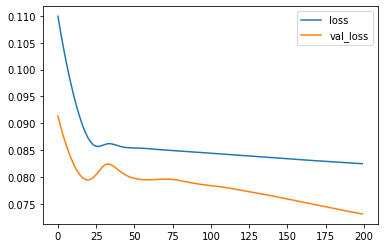

In [33]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()

In [35]:
def model_forecast(model, series, window_size,size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [37]:
Forecast = model_forecast(model, sales_per_day["Scaled"].values[:, np.newaxis], WINDOW_SIZE, SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 1s 762ms/step


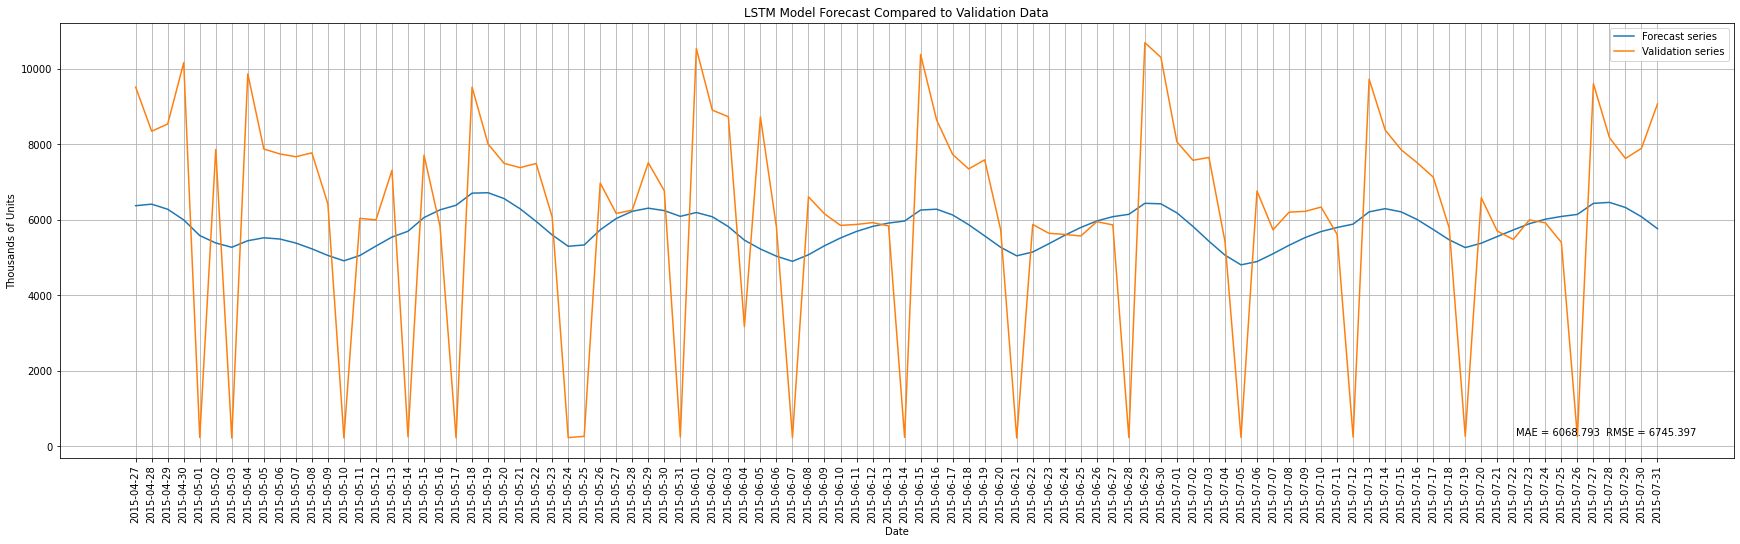

MAE = 6068.793  RMSE = 6745.397


In [38]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()
print(textstr)

In [39]:
model_timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_file_path = os.path.join(pwd, os.pardir, 'models')

In [40]:
dump(filename=f'{model_file_path}/LSTM-{model_timestamp}.pkl', value=model, compress=9)

INFO:tensorflow:Assets written to: ram://e607023c-8aa0-4df6-b2fc-9e57a7b4743e/assets


INFO:tensorflow:Assets written to: ram://e607023c-8aa0-4df6-b2fc-9e57a7b4743e/assets


['c:\\Users\\user\\Desktop\\10_Academy\\Week_3\\Technical\\Pharmaceutical-Sales\\notebooks\\..\\models/LSTM-2022-05-28-19-43-27.pkl']